In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
from einops import rearrange
from pytorch_lightning import LightningModule, Trainer, loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import StepLR
from torch import nn, optim
import lightning as L
import rasterio

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

/home/ate/miniconda3/envs/clay/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "/media/ate/ssd/mrv/patch128/"

In [3]:
from finetune.change.datamodule import changeDataModule

# Data configuration
path = "/media/ate/ssd/mrv/patch128/"
train_before_chip_dir = path +"before/"
train_after_chip_dir = path +"after/"
train_label_dir = path +"label/"
val_before_chip_dir = path +"before/"
val_after_chip_dir = path +"after/"
val_label_dir = path +"label/"
metadata_path = "configs/metadata.yaml"
batch_size = 4
num_workers = 4
platform = "sentinel-2-l2a"

# Initialize ChangeDataModule
change_data_module = changeDataModule(
    train_before_chip_dir=train_before_chip_dir,
    train_after_chip_dir=train_after_chip_dir,
    train_label_dir=train_label_dir,
    val_before_chip_dir=val_before_chip_dir,
    val_after_chip_dir=val_after_chip_dir,
    val_label_dir=val_label_dir,
    metadata_path=metadata_path,
    batch_size=batch_size,
    num_workers=num_workers,
    platform=platform,
)

# Setup the datasets
change_data_module.setup(stage="fit")

# Access the first item from the training dataloader
train_loader = change_data_module.train_dataloader()
val_loader = change_data_module.val_dataloader()


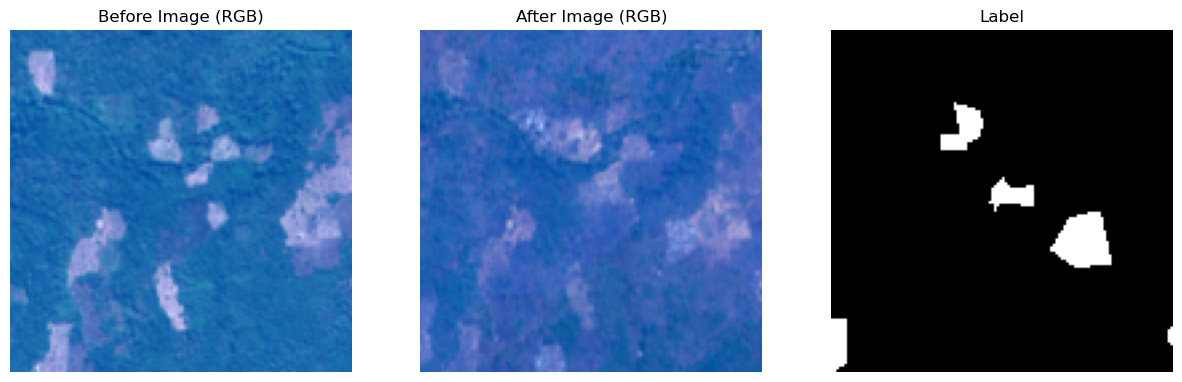

In [4]:
import matplotlib.pyplot as plt
import torch

batch = next(iter(train_loader))
# Assuming your batch is stored in a variable `batch`
before_pixels = batch['before']['pixels'][0]  # Select the first image in the batch
after_pixels = batch['after']['pixels'][0]    # Select the first image in the batch
label = batch['label'][0]                     # Select the first label in the batch

# Extract RGB channels (assuming Sentinel-2 has them in bands [2, 1, 0] for RGB)
before_rgb = before_pixels[[2, 1, 0], :, :]   # Extract R, G, B channels for 'before' image
after_rgb = after_pixels[[2, 1, 0], :, :]     # Extract R, G, B channels for 'after' image

# Normalize the data to [0, 1] range for visualization
before_rgb = (before_rgb - before_rgb.min()) / (before_rgb.max() - before_rgb.min())
after_rgb = (after_rgb - after_rgb.min()) / (after_rgb.max() - after_rgb.min())

# Plot before, after, and label images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot before image
axs[0].imshow(before_rgb.permute(1, 2, 0).cpu().numpy())  # Transpose to HxWxC for matplotlib
axs[0].set_title('Before Image (RGB)')
axs[0].axis('off')

# Plot after image
axs[1].imshow(after_rgb.permute(1, 2, 0).cpu().numpy())
axs[1].set_title('After Image (RGB)')
axs[1].axis('off')

# Plot label
axs[2].imshow(label[0].cpu().numpy(), cmap='gray')  # Assuming label is a single channel
axs[2].set_title('Label')
axs[2].axis('off')

plt.show()


In [5]:
# Import the changeSegmentor class
from finetune.change.model import changeSegmentor

# Initialize the model with required parameters
model = changeSegmentor(
    num_classes=2,
    feature_maps=[3, 5, 7, 11],  # Example feature maps
    ckpt_path="/home/ate/sig/gitmodels/clay_new/model/checkpoints/clay-v1-base.ckpt",  # Replace with the path to your checkpoint
    lr=1e-5,
    wd=0.05,
    b1=0.9,
    b2=0.95,
)

# Check if the model loads correctly
print(model)

/home/ate/miniconda3/envs/clay/envs/claymodel/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


changeSegmentor(
  (model): Segmentor(
    (encoder): SegmentEncoder(
      (patch_embedding): DynamicEmbedding(
        (weight_generator): WavesTransformer(
          (encoder): TransformerEncoder(
            (layers): ModuleList(
              (0): TransformerEncoderLayer(
                (self_attn): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
                )
                (linear1): Linear(in_features=128, out_features=2048, bias=True)
                (dropout): Dropout(p=0, inplace=False)
                (linear2): Linear(in_features=2048, out_features=128, bias=True)
                (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (dropout1): Dropout(p=0, inplace=False)
                (dropout2): Dropout(p=0, inplace=False)
              )
            )
          )
          (fc_weig

In [6]:
# Set up the trainer with desired parameters
trainer = L.Trainer(
    max_epochs=2,             # Adjust epochs based on your requirements
    log_every_n_steps=1       # Adjust the logging frequency as needed
)

# Start training
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | Segmentor          | 110 M 
1 | loss_fn | BCEWithLogitsLoss  | 0     
2 | iou     | BinaryJaccardIndex | 0     
3 | f1      | BinaryF1Score      | 0     
-----------------------------------------------
18.9 M    Trainable params
92.1 M    Non-trainable params
110 M     Total params
443.978   Total estimated model params size (MB)


/home/ate/miniconda3/envs/clay/envs/claymodel/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:09<00:00, 10.43it/s, v_num=6]
Validation: |                                                                                                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:09<00:00, 10.53it/s, v_num=6, val/loss=0.180, val/iou=0.902, val/f1=0.948, train/loss=0.398, train/iou=0.827, train/f1=0.898]
Validation: |                              

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:16<00:00,  5.88it/s, v_num=6, val/loss=0.135, val/iou=0.914, val/f1=0.955, train/loss=0.153, train/iou=0.907, train/f1=0.951]


In [7]:
predictions = trainer.predict(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:05<00:00, 16.72it/s]


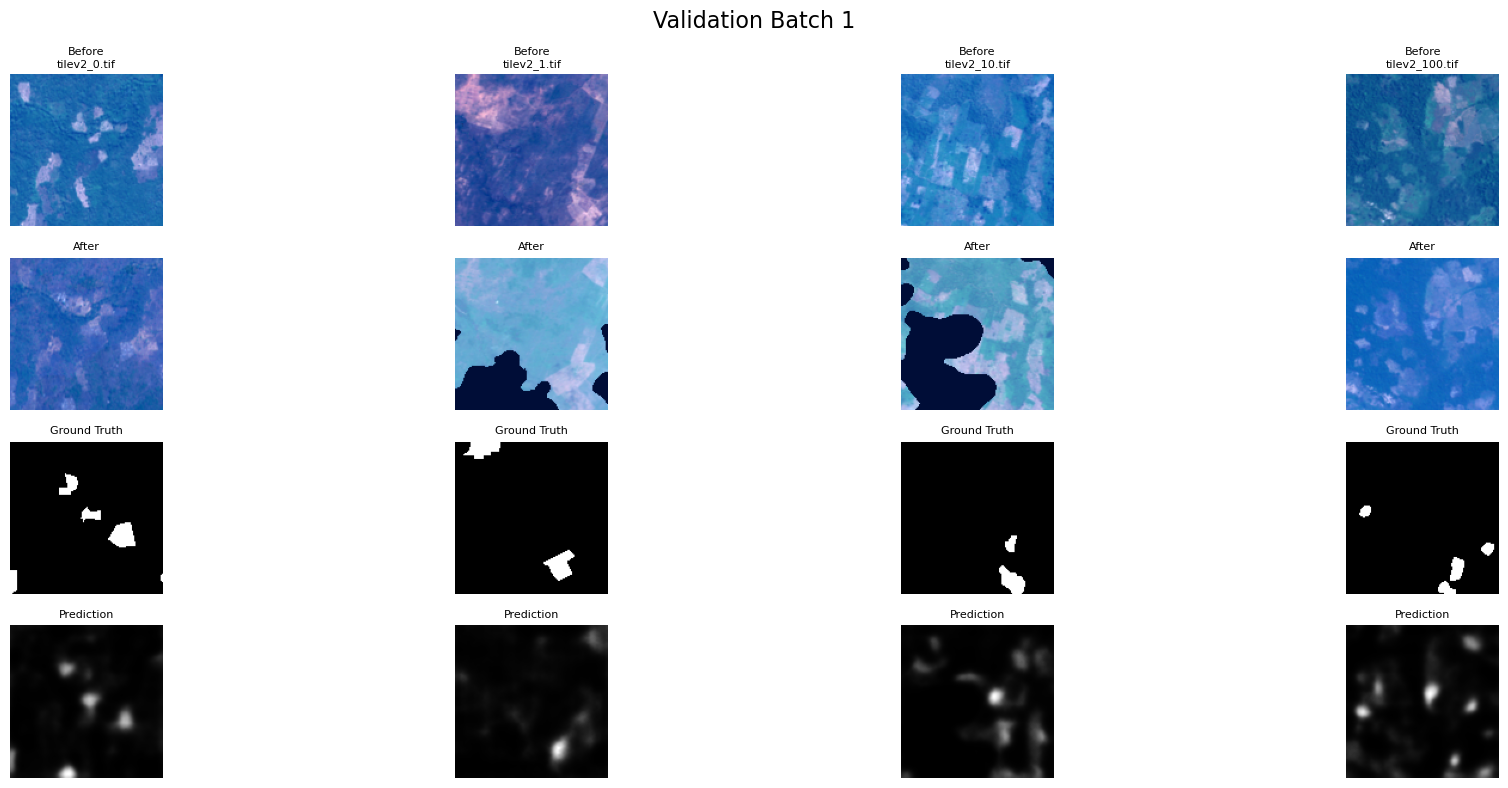

In [8]:
# Iterate over the validation dataset and predictions, but only display the first batch
for batch_idx, (batch, pred) in enumerate(zip(val_loader, predictions)):
    if batch_idx > 0:
        break  # Only display the first batch
    
    filenames = batch['filename'] if 'filename' in batch else [f"Patch {i}" for i in range(len(batch['before']['pixels']))]
    before_patches = batch['before']['pixels']
    after_patches = batch['after']['pixels']
    labels = batch['label']
    
    # Set up a figure with 4 columns (before, after, ground truth label, predicted label)
    fig, axs = plt.subplots(4, 4, figsize=(20, 8))
    fig.suptitle(f'Validation Batch {batch_idx+1}', fontsize=16)

    # Loop over each patch in the batch (limit to the first 10 patches)
    for i in range(min(4, len(filenames))):
        before_patch = before_patches[i][[2, 1, 0], :, :]  # Assuming RGB channels
        after_patch = after_patches[i][[2, 1, 0], :, :]
        label_patch = labels[i][0]  # Assuming a single channel for label
        pred_patch = pred[i][0]  # Assuming prediction is also a single-channel binary mask

        # Normalize before and after images for display
        before_rgb = (before_patch - before_patch.min()) / (before_patch.max() - before_patch.min())
        after_rgb = (after_patch - after_patch.min()) / (after_patch.max() - after_patch.min())

        # Display images
        axs[0, i].imshow(before_rgb.permute(1, 2, 0).cpu().numpy())  # HWC format for plotting
        axs[0, i].set_title(f'Before\n{filenames[i]}', fontsize=8)
        axs[0, i].axis('off')

        axs[1, i].imshow(after_rgb.permute(1, 2, 0).cpu().numpy())
        axs[1, i].set_title('After', fontsize=8)
        axs[1, i].axis('off')

        axs[2, i].imshow(label_patch.cpu().numpy(), cmap='gray')
        axs[2, i].set_title('Ground Truth', fontsize=8)
        axs[2, i].axis('off')

        axs[3, i].imshow(pred_patch.cpu().numpy(), cmap='gray')
        axs[3, i].set_title('Prediction', fontsize=8)
        axs[3, i].axis('off')

    plt.tight_layout()
    plt.show()
